# Real Estate Price Predictions

Notebook com predição do preço por unidade de área de casas.  
Dataset extraído do kaggle (https://www.kaggle.com/datasets/quantbruce/real-estate-price-prediction)

In [35]:
# Importando pacotes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import re
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Visualizando os dados
df = pd.read_csv('Real estate.csv')

In [3]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


#

## Data Cleaning

In [4]:
# Drop da primeira coluna
df.drop('No', axis=1, inplace = True)

In [5]:
# Renomeando as colunas
df.rename(columns= {'X1 transaction date': 'Data Transacao',
                    'X2 house age': 'Idade casa',
                    'X3 distance to the nearest MRT station': 'Distancia da estacao metro',
                    'X4 number of convenience stores': 'Numero lojas conveniencia',
                    'X5 latitude': 'Latitude',
                    'X6 longitude': 'Longitude',
                    'Y house price of unit area': 'Preco por unidade de area'}, inplace=True)

In [6]:
df.head()

,Data Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [7]:
# Verificação de registros duplicados
df.duplicated().sum() # Não há

0

In [8]:
# Verificação de valores ausentes
df.isna().sum() # Não há

Data Transacao                0
Idade casa                    0
Distancia da estacao metro    0
Numero lojas conveniencia     0
Latitude                      0
Longitude                     0
Preco por unidade de area     0
dtype: int64

## Pré-Processamento de Dados

In [9]:
# Separando a coluna "Data Transacao" em ano e mês.
ano_mes = df['Data Transacao'].apply(lambda x: str(x).split('.'))

ano = [year[0] for year in ano_mes]
mes = [month[1] for month in ano_mes]

df['Ano Transacao'] = ano
df['Mes Transacao'] = mes


In [10]:
df.head()

,Data Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area,Ano Transacao,Mes Transacao
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9,2012,917
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2,2012,917
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3,2013,583
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8,2013,5
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1,2012,833


In [11]:
# Mudar posiçao das colunas de data e remover a inicial
mudar_posicao1 = df.pop('Ano Transacao')
mudar_posicao2 = df.pop('Mes Transacao')
remove_coluna = df.pop('Data Transacao')

df.insert(0, 'Ano Transacao', mudar_posicao1)
df.insert(1, 'Mes Transacao', mudar_posicao2)

In [12]:
df.head()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area
0,2012,917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012,917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013,583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013,5,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012,833,5.0,390.56840,5,24.97937,121.54245,43.1


In [13]:
# Agora é preciso adequar a coluna 'Mes Transacao' para ficar de 0 a 12 (Jan-Dez)
df['Mes Transacao'] = [int(mes)/83.33 for mes in df['Mes Transacao']]
df.head()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area
0,2012,11.004440,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012,11.004440,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013,6.996280,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013,0.060002,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012,9.996400,5.0,390.56840,5,24.97937,121.54245,43.1


In [14]:
for i in range(0, len(df)):
    if df['Mes Transacao'][i] < 1:
         df['Mes Transacao'][i] = 1
    elif df['Mes Transacao'][i] < 2:
         df['Mes Transacao'][i] = 2
    elif df['Mes Transacao'][i] < 3:
         df['Mes Transacao'][i] = 3
    elif df['Mes Transacao'][i] < 4:
         df['Mes Transacao'][i] = 4
    elif df['Mes Transacao'][i] < 5:
         df['Mes Transacao'][i] = 5
    elif df['Mes Transacao'][i] < 6:
         df['Mes Transacao'][i] = 6
    elif df['Mes Transacao'][i] < 7:
         df['Mes Transacao'][i] = 7
    elif df['Mes Transacao'][i] < 8:
         df['Mes Transacao'][i] = 8
    elif df['Mes Transacao'][i] < 9:
         df['Mes Transacao'][i] = 9
    elif df['Mes Transacao'][i] < 10:
         df['Mes Transacao'][i] = 10
    elif df['Mes Transacao'][i] < 11:
         df['Mes Transacao'][i] = 11
    elif df['Mes Transacao'][i] < 12:
         df['Mes Transacao'][i] = 12

# Transformndo a coluna de mês em inteiro
df = df.astype({'Mes Transacao': 'int'})
df = df.astype({'Ano Transacao': 'int'})

In [15]:
df[(df['Mes Transacao']== '1')]

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area


In [16]:
df.head()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Latitude,Longitude,Preco por unidade de area
0,2012,12,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012,12,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013,7,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013,1,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012,10,5.0,390.56840,5,24.97937,121.54245,43.1


In [17]:
# Removendo as colunas 'Latitude' e 'Longitude' pois não serão necessárias.
df.drop(['Latitude', 'Longitude'],axis =1 , inplace = True)
df.head()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Preco por unidade de area
0,2012,12,32.0,84.87882,10,37.9
1,2012,12,19.5,306.59470,9,42.2
2,2013,7,13.3,561.98450,5,47.3
3,2013,1,13.3,561.98450,5,54.8
4,2012,10,5.0,390.56840,5,43.1


## Análise Exploratória

In [18]:
df.describe()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Preco por unidade de area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2012.695652,4.628019,17.712560,1083.885689,4.094203,37.980193
std,0.460687,3.880389,11.392485,1262.109595,2.945562,13.606488
min,2012.000000,1.000000,0.000000,23.382840,0.000000,7.600000
25%,2012.000000,1.000000,9.025000,289.324800,1.000000,27.700000
50%,2013.000000,4.000000,16.100000,492.231300,4.000000,38.450000
75%,2013.000000,7.000000,28.150000,1454.279000,6.000000,46.600000
max,2013.000000,12.000000,43.800000,6488.021000,10.000000,117.500000


In [19]:
# Não temos todos os meses do ano. Ao inves de separar por ano, talvez seja ideal separar por quarter (trimestre).
df['Mes Transacao'].unique()

array([12,  7,  1, 10,  9,  6,  4,  3])

In [20]:
# Transformando a coluna mes em trimestre.
for i in range(0, len(df)):
    if df['Mes Transacao'][i] <= 3:
        df['Mes Transacao'][i] = 'Q1'
    elif df['Mes Transacao'][i] <= 6:
        df['Mes Transacao'][i] = 'Q2'
    elif df['Mes Transacao'][i] <= 9:
        df['Mes Transacao'][i] = 'Q3'    
    elif df['Mes Transacao'][i] <= 12:
        df['Mes Transacao'][i] = 'Q4'
        
df['Mes Transacao'].value_counts()

Q1    205
Q2     87
Q4     69
Q3     53
Name: Mes Transacao, dtype: int64

In [21]:
# Temos apenas dois anos diferentes
df['Ano Transacao'].value_counts()

2013    288
2012    126
Name: Ano Transacao, dtype: int64

<AxesSubplot:>

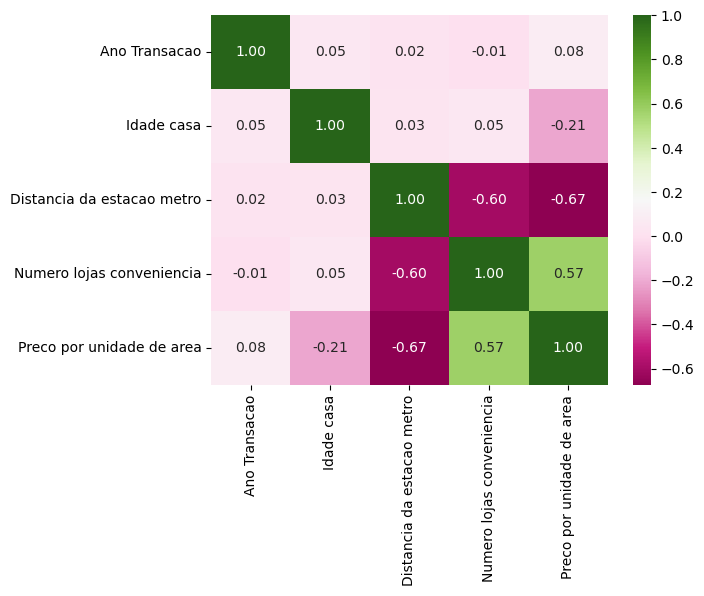

In [22]:
# Correlação
correlacao = df.corr()
sns.heatmap(correlacao, cmap = 'PiYG', annot = True, fmt = '.2f')

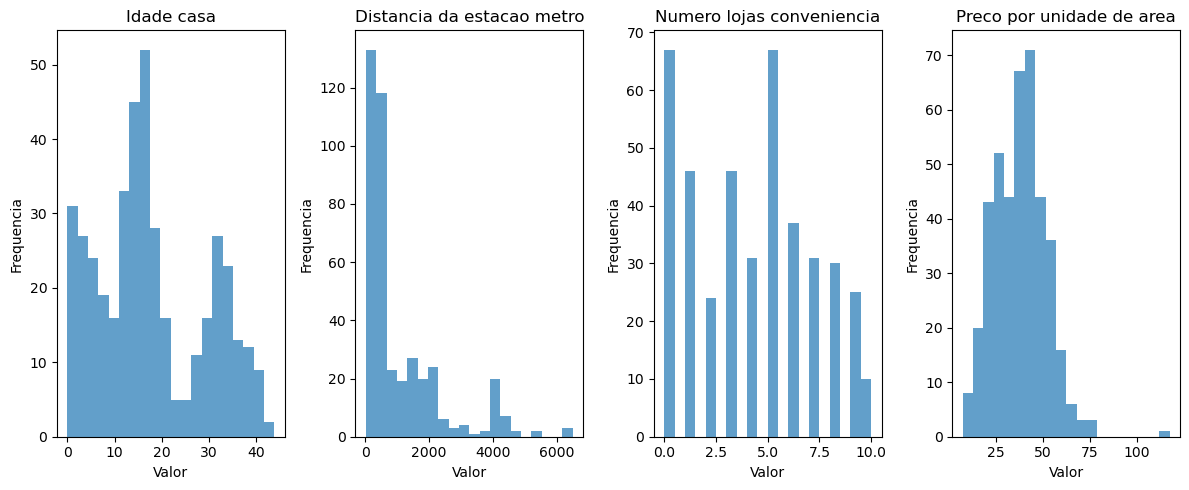

In [23]:
# Visualização das variáveis preditoras
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(12,5))

# Numero de bins
bins = 20

for i, data in enumerate([df['Idade casa'], df['Distancia da estacao metro'], df['Numero lojas conveniencia'], df['Preco por unidade de area']]):
    axs[i].hist(data, bins = bins, alpha = 0.7)
    axs[i].set_xlabel('Valor')
    axs[i].set_ylabel('Frequencia')
    axs[i].set_title(f'{df.columns[i+2]}')
    
plt.tight_layout()
    
plt.show()

In [24]:
df.head()

,Ano Transacao,Mes Transacao,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Preco por unidade de area
0,2012,Q4,32.0,84.87882,10,37.9
1,2012,Q4,19.5,306.59470,9,42.2
2,2013,Q3,13.3,561.98450,5,47.3
3,2013,Q1,13.3,561.98450,5,54.8
4,2012,Q4,5.0,390.56840,5,43.1


### Dummização das variáveis Ano e Mês

In [25]:
df_dummies = pd.get_dummies(df, columns=['Ano Transacao', 'Mes Transacao'], drop_first= True)
df_dummies.head()

,Idade casa,Distancia da estacao metro,Numero lojas conveniencia,Preco por unidade de area,Ano Transacao_2013,Mes Transacao_Q2,Mes Transacao_Q3,Mes Transacao_Q4
0,32.0,84.87882,10,37.9,0,0,0,1
1,19.5,306.59470,9,42.2,0,0,0,1
2,13.3,561.98450,5,47.3,1,0,1,0
3,13.3,561.98450,5,54.8,1,0,0,0
4,5.0,390.56840,5,43.1,0,0,0,1


## Modelo

In [26]:
# Separando os dados em dados de treino e dados de teste
X = df_dummies.drop('Preco por unidade de area', axis = 1)
y = df_dummies['Preco por unidade de area']

X_train, X_teste, y_train, y_teste = train_test_split(X, y, test_size=0.25)

In [27]:
# Vamos fazer a padronização dos dados visto que as variáveis se encontram em grandezas diferentes
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_teste = scaler.transform(X_teste)

In [28]:
# Verificar se foi devidamente padronizado
print(f'Desvio Padrao: {X_train.std()}')
print(f'Média: {X_train.mean()}')

Desvio Padrao: 1.0
Média: 3.1925307251893905e-17


In [29]:
# Modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

In [31]:
# Coeficientes
coef = modelo.coef_
pd.DataFrame(data = coef, index = X.columns, columns=['Coeficientes'])

,Coeficientes
Idade casa,-3.181693
Distancia da estacao metro,-6.827480
Numero lojas conveniencia,4.080905
Ano Transacao_2013,2.212820
Mes Transacao_Q2,0.061839
Mes Transacao_Q3,0.919173
Mes Transacao_Q4,1.050666


In [30]:
modelo.intercept_
y_predicted = modelo.predict(X_teste)

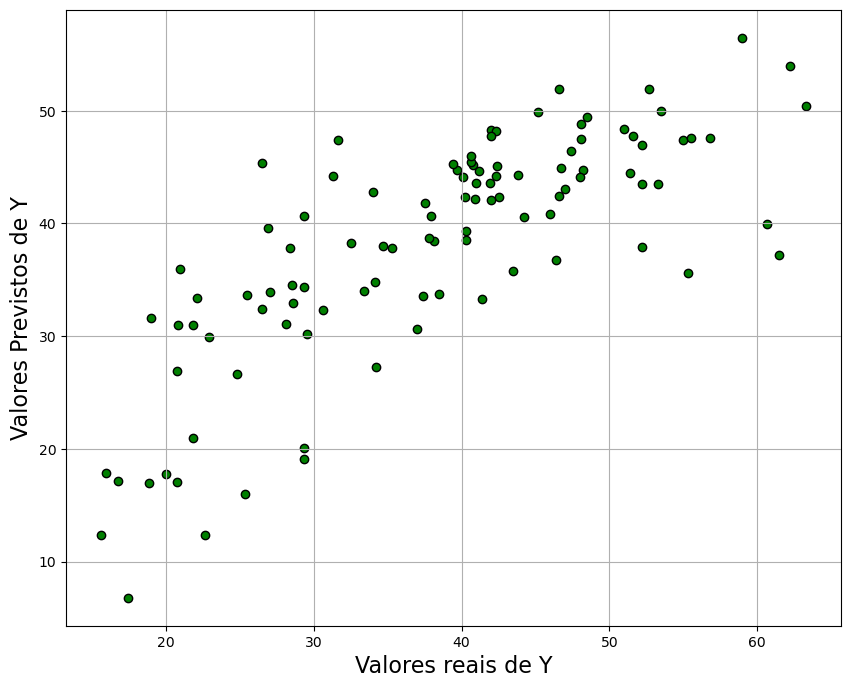

In [33]:
# Plot dos dados previstos com os reais
plt.figure(figsize=(10,8))

plt.scatter(x = y_teste, y = y_predicted, color = 'green', edgecolors= 'black')
plt.xlabel('Valores reais de Y', fontdict={'fontsize': 16})
plt.ylabel('Valores Previstos de Y', fontdict={'fontsize': 16})
plt.grid(True)

In [37]:
# Métricas de avaliação do modelo
mean_squared_error(y_teste, y_predicted)# Mean Squared Error

57.74862099159055

In [38]:
mean_absolute_error(y_teste, y_predicted)# MAE - Mean Absolute Error

5.886711750470723

In [40]:
r2_score(y_teste, y_predicted) # R²

0.5883127359257709